# Mining Twitter

Twitter implements OAuth 1.0A as its standard authentication mechanism, and in order to use it to make requests to Twitter's API, you'll need to go to https://developer.twitter.com/en/apps and create a sample application. It is possible that Twitter no longer supports sandboxed applications and you may need to submit a request for permission to develop an app on Twitter.

There are four primary identifiers you'll need to note for an OAuth 1.0A workflow: consumer key, consumer secret, access token, and access token secret. Note that you will need an ordinary Twitter account in order to login, create an app, and get these credentials.

<img src="resources/ch01-twitter/images/Twitter-AppCredentials.png" width="600px">

If you are running this code on Binder or from the Docker container, you should just be able to execute the code in this notebook without any worries whatsoever about installing dependencies. If you are running the code from your own development envioronment, however, be advised that these examples in this chapter take advantage of a Python package called [twitter](https://github.com/sixohsix/twitter) to make API calls. You can install this package in a terminal with [pip](https://pypi.python.org/pypi/pip) with the command `pip install twitter`, preferably from within a [Python virtual environment](https://pypi.python.org/pypi/virtualenv). 

Once installed, you should be able to open up a Python interpreter (or better yet, your [IPython](http://ipython.org/) interpreter) and get rolling.

## Authorizing an application to access Twitter account data

In [2]:
import twitter
import os

# settings.py
from os.path import join, dirname
from dotenv import load_dotenv
load_dotenv('./.env')


# Create .env file path.
#dotenv_path = join(dirname(__file__), '.env')
 
# Load file from the path.
#load_dotenv(dotenv_path)

# Go to https://developer.twitter.com/en/apps to create an app and get values
# for these credentials, which you'll need to provide in place of these
# empty string values that are defined as placeholders.
# See https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
# for more information on Twitter's OAuth implementation.

CONSUMER_KEY = os.getenv('TWITTER_CONSUMER_KEY')
CONSUMER_SECRET = os.getenv('TWITTER_CONSUMER_SECRET')
OAUTH_TOKEN = os.getenv('TWITTER_OAUTH_TOKEN')
OAUTH_TOKEN_SECRET = os.getenv('TWITTER_OAUTH_TOKEN_SECRET')

auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)

twitter_api = twitter.Twitter(auth=auth)

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print(twitter_api)

## Retrieving trends

In [32]:
# The Yahoo! Where On Earth ID for the entire world is 1.
# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/

WORLD_WOE_ID = 1
US_WOE_ID = 23424977

# Prefix ID with the underscore for query string parameterization.
# Without the underscore, the twitter package appends the ID value
# to the URL itself as a special case keyword argument.

world_trends = twitter_api.trends.place(_id=WORLD_WOE_ID)
us_trends = twitter_api.trends.place(_id=US_WOE_ID)

print(world_trends)
print()
print(us_trends)

[{'trends': [{'name': '#AlwaysWithJK', 'url': 'http://twitter.com/search?q=%23AlwaysWithJK', 'promoted_content': None, 'query': '%23AlwaysWithJK', 'tweet_volume': 162006}, {'name': '#BienvenidaSwitchLite', 'url': 'http://twitter.com/search?q=%23BienvenidaSwitchLite', 'promoted_content': None, 'query': '%23BienvenidaSwitchLite', 'tweet_volume': None}, {'name': '#1JutaRameinTwitter', 'url': 'http://twitter.com/search?q=%231JutaRameinTwitter', 'promoted_content': None, 'query': '%231JutaRameinTwitter', 'tweet_volume': 19103}, {'name': '#あなたの体調不良の原因上位5つ', 'url': 'http://twitter.com/search?q=%23%E3%81%82%E3%81%AA%E3%81%9F%E3%81%AE%E4%BD%93%E8%AA%BF%E4%B8%8D%E8%89%AF%E3%81%AE%E5%8E%9F%E5%9B%A0%E4%B8%8A%E4%BD%8D5%E3%81%A4', 'promoted_content': None, 'query': '%23%E3%81%82%E3%81%AA%E3%81%9F%E3%81%AE%E4%BD%93%E8%AA%BF%E4%B8%8D%E8%89%AF%E3%81%AE%E5%8E%9F%E5%9B%A0%E4%B8%8A%E4%BD%8D5%E3%81%A4', 'tweet_volume': None}, {'name': '#AdnanMenderes', 'url': 'http://twitter.com/search?q=%23AdnanMenderes',

In [33]:
for trend in world_trends[0]['trends']:
    print(trend['name'])

#AlwaysWithJK
#BienvenidaSwitchLite
#1JutaRameinTwitter
#あなたの体調不良の原因上位5つ
#AdnanMenderes
ドゥムジ
安定の5等
シドゥリさん
観艦式
보증금
고시원
全るーみっくアニメ大投票
懲役8年
非リア充
청년주택
#HappyBdayPMModi
#TuesdayThoughts
#MHWアイスボーン狩猟解禁
#الهلال_الاتحاد_دوري_اسيا
#HazıraKonucuCHP
#500LeRiaHai
#あなたの声のランクは
#كفايه_بقي_ياسيسيي
#TellEm131
#Renzi
#salı
#WorldPatientSafetyDay
#AnnelerDiyarbakırda
#KuralHatasiVarTff
#SupremeCourtFacts
#ChampionsLeague
#صباح_الثلاثاء
#EmperorOfPollsTHALAFans
#ความห่วงใยจากแดนไกล
#ParalarNerede
#曲名の一部をもやしにすると弱い
#人に言うと引かれちゃう事
#الاسيويه_صعبه_قويه
#ประยุทธ์อยู่ไหน
#بوبيان_كل_ثلاثاء
#prinsjesdag2019
#17Settembre
#SomebodyNew
#DünyaküfürGünü
#MiTV
#HBDPERIYAR141
#JusticeForNimrita
#TRINITYDEBUT
#MOONCHILDCHALLENGE
#RiveraAR


In [34]:
for trend in us_trends[0]['trends']:
    print(trend['name'])

#AlwaysWithJK
#tuesdaythoughts
#BiWeek
#StrangeThingsParentsSay
#TMobileTuesdays
Too Many Zooz
Steve Cortes
Diekman
High Court
SIFAS
bring the soul
Ramsey
Jets
Kavanaugh
Iran
Myles Garrett
Ben Shapiro
Rudolph
Saudi Arabia
Big Ben
Odell
Steelers
The Cars
#TuesdayMorning
#howtobeaboss
#MillennialRetirementPlans
#IBuiltASecurityFenceBecause
#HappyBdayPMModi
#tellem131
#strangefestivalthemes
#ipres2019
#DLRCastLife
#SomebodyNew
#recsys2019
#WorldPatientSafetyDay
#hauslabs
#RutoMasterOfDivision
#bfc530
#beatNTDs
#carnivorous
#HappinessBeginsTourStPaul
#monsoon
#HausLaboratories
#IsaPaWithFeelingsAmainezing
#DWTSPremiere
#CLEvsNYJ
#PleaseAWomanIn5Words
#MakingTheGift
#MondayMotivation
#Browns


In [35]:
world_trends_set = set([trend['name'] 
                        for trend in world_trends[0]['trends']])

us_trends_set = set([trend['name'] 
                     for trend in us_trends[0]['trends']]) 

common_trends = world_trends_set.intersection(us_trends_set)

print(common_trends)

{'#HappyBdayPMModi', '#SomebodyNew', '#WorldPatientSafetyDay', '#AlwaysWithJK'}


## Anatomy of a Tweet

In [42]:
import json

# Set this variable to a trending topic, 
# or anything else for that matter. The example query below
# was a trending topic when this content was being developed
# and is used throughout the remainder of this chapter.

q = 'bitcoin' 

count = 100

# Import unquote to prevent url encoding errors in next_results
from urllib.parse import unquote

# See https://dev.twitter.com/rest/reference/get/search/tweets

search_results = twitter_api.search.tweets(q=q, count=count)

statuses = search_results['statuses']


# Iterate through 5 more batches of results by following the cursor
for _ in range(5):
    print('Length of statuses', len(statuses))
    try:
        next_results = search_results['search_metadata']['next_results']
    except KeyError as e: # No more results when next_results doesn't exist
        break
        
    # Create a dictionary from next_results, which has the following form:
    # ?max_id=847960489447628799&q=%23RIPSelena&count=100&include_entities=1
    kwargs = dict([ kv.split('=') for kv in unquote(next_results[1:]).split("&") ])
    
    search_results = twitter_api.search.tweets(**kwargs)
    statuses += search_results['statuses']

# Show one sample search result by slicing the list...
print(json.dumps(statuses[0], indent=1))

Length of statuses 100
Length of statuses 200
Length of statuses 300
Length of statuses 393
Length of statuses 490
{
 "created_at": "Tue Sep 17 10:44:21 +0000 2019",
 "id": 1173910558204149761,
 "id_str": "1173910558204149761",
 "text": "If you are looking for a blockchain programmer you can write to me I can do coding for billing systems with cryptoc\u2026 https://t.co/0CvxMKRyR3",
 "truncated": true,
 "entities": {
  "hashtags": [],
  "symbols": [],
  "user_mentions": [],
  "urls": [
   {
    "url": "https://t.co/0CvxMKRyR3",
    "expanded_url": "https://twitter.com/i/web/status/1173910558204149761",
    "display_url": "twitter.com/i/web/status/1\u2026",
    "indices": [
     117,
     140
    ]
   }
  ]
 },
 "metadata": {
  "iso_language_code": "en",
  "result_type": "recent"
 },
 "source": "<a href=\"http://twitter.com/download/iphone\" rel=\"nofollow\">Twitter for iPhone</a>",
 "in_reply_to_status_id": null,
 "in_reply_to_status_id_str": null,
 "in_reply_to_user_id": null,
 "in_re

In [43]:
for i in range(10):
    print()
    print(statuses[i]['text'])
    print('Favorites: ', statuses[i]['favorite_count'])
    print('Retweets: ', statuses[i]['retweet_count'])


If you are looking for a blockchain programmer you can write to me I can do coding for billing systems with cryptoc… https://t.co/0CvxMKRyR3
Favorites:  0
Retweets:  0

#Bitcoin Price (#BTC) At Clear Risk of Further Declines: - Bitcoin price failed to hold the key $10… https://t.co/xHSx8oAySB #Blockchain
Favorites:  0
Retweets:  0

Crypto Beadles Is BULLISH on Bitcoin Cash! Full Interview Tron Event! https://t.co/GCbQfPi8Cn https://t.co/biPEEDMy1B
Favorites:  0
Retweets:  0

compren bitcoin o dai si no quieren la volatilidad. esta gente no entiende una verga de nada. https://t.co/pbi8CTSJHs
Favorites:  0
Retweets:  0

ビットコイン先物取引始まる！Bakktやバイナンスに続きhttps://t.co/Aum9jwQ8Piでもサービス開始か？ https://t.co/sL8y07utQW https://t.co/DNpAVIDBnk
Favorites:  0
Retweets:  0

Please fund my new #bitcoin #LightningNetwork wallet from your #faucet so I can play EscapeQR! https://t.co/aIEmHK8rlA
Favorites:  0
Retweets:  0

RT @MatiGreenspan: Bitcoin dominance is now comparable to where it was before there was 

## Extracting text, screen names, and hashtags from tweets

In [52]:
status_texts = [ status['text'] 
                 for status in statuses ]

screen_names = [ user_mention['screen_name'] 
                 for status in statuses
                     for user_mention in status['entities']['user_mentions'] ]

hashtags = [ hashtag['text'] 
             for status in statuses
                 for hashtag in status['entities']['hashtags'] ]

# Compute a collection of all words from all tweets
words = [ w 
          for t in status_texts 
              for w in t.split() ]

# Explore the first 5 items for each...

print(json.dumps(status_texts[0:5], indent=1))
print(json.dumps(screen_names[0:5], indent=1) )
print(json.dumps(hashtags[0:5], indent=1))
print(json.dumps(words[0:5], indent=1))

[
 "If you are looking for a blockchain programmer you can write to me I can do coding for billing systems with cryptoc\u2026 https://t.co/0CvxMKRyR3",
 "#Bitcoin Price (#BTC) At Clear Risk of Further Declines: - Bitcoin price failed to hold the key $10\u2026 https://t.co/xHSx8oAySB #Blockchain",
 "Crypto Beadles Is BULLISH on Bitcoin Cash! Full Interview Tron\u00a0Event! https://t.co/GCbQfPi8Cn https://t.co/biPEEDMy1B",
 "compren bitcoin o dai si no quieren la volatilidad. esta gente no entiende una verga de nada. https://t.co/pbi8CTSJHs",
 "\u30d3\u30c3\u30c8\u30b3\u30a4\u30f3\u5148\u7269\u53d6\u5f15\u59cb\u307e\u308b\uff01Bakkt\u3084\u30d0\u30a4\u30ca\u30f3\u30b9\u306b\u7d9a\u304dhttps://t.co/Aum9jwQ8Pi\u3067\u3082\u30b5\u30fc\u30d3\u30b9\u958b\u59cb\u304b\uff1f https://t.co/sL8y07utQW https://t.co/DNpAVIDBnk"
]
[
 "MatiGreenspan",
 "alistairmilne",
 "OrionixToken",
 "CengizH79163104",
 "Street5Wall"
]
[
 "Bitcoin",
 "BTC",
 "Blockchain",
 "bitcoin",
 "LightningNetwork"
]
[
 "If",
 

## Creating a basic frequency distribution from the words in tweets

In [53]:
from collections import Counter

for item in [words, screen_names, hashtags]:
    c = Counter(item)
    print(c.most_common()[:10]) # top 10
    print()

[('RT', 232), ('the', 189), ('Bitcoin', 179), ('-', 133), ('of', 122), ('to', 103), ('in', 102), ('is', 100), ('a', 91), ('for', 70)]

[('CincinnatusBTC', 13), ('freebitcoinsy', 13), ('Cointelegraph', 11), ('1jl4com', 11), ('Crypto____World', 8), ('YarKafanchan', 7), ('Bakkt', 7), ('malekalby', 6), ('sumawun', 6), ('JanetNestor', 6)]

[('bitcoin', 58), ('Bitcoin', 57), ('BTC', 22), ('blockchain', 20), ('crypto', 20), ('cryptocurrency', 16), ('Crypto', 13), ('Blockchain', 12), ('仮想通貨', 10), ('Ethereum', 9)]



## Using prettytable to display tuples in a nice tabular format

In [54]:
from prettytable import PrettyTable

for label, data in (('Word', words), 
                    ('Screen Name', screen_names), 
                    ('Hashtag', hashtags)):
    pt = PrettyTable(field_names=[label, 'Count']) 
    c = Counter(data)
    [ pt.add_row(kv) for kv in c.most_common()[:20] ]
    pt.align[label], pt.align['Count'] = 'l', 'r' # Set column alignment
    print(pt)

+----------+-------+
| Word     | Count |
+----------+-------+
| RT       |   232 |
| the      |   189 |
| Bitcoin  |   179 |
| -        |   133 |
| of       |   122 |
| to       |   103 |
| in       |   102 |
| is       |   100 |
| a        |    91 |
| for      |    70 |
| and      |    58 |
| The      |    55 |
| #bitcoin |    53 |
| #Bitcoin |    48 |
| on       |    46 |
| with     |    43 |
| you      |    42 |
| bitcoin  |    42 |
| I        |    40 |
| de       |    31 |
+----------+-------+
+-----------------+-------+
| Screen Name     | Count |
+-----------------+-------+
| CincinnatusBTC  |    13 |
| freebitcoinsy   |    13 |
| Cointelegraph   |    11 |
| 1jl4com         |    11 |
| Crypto____World |     8 |
| YarKafanchan    |     7 |
| Bakkt           |     7 |
| malekalby       |     6 |
| sumawun         |     6 |
| JanetNestor     |     6 |
| Kugey           |     6 |
| grazytgrazynatt |     6 |
| wanderingstarz1 |     6 |
| PapaPorter1     |     6 |
| heroldbarton    | 

## Calculating lexical diversity for tweets

In [55]:
# A function for computing lexical diversity
def lexical_diversity(tokens):
    return len(set(tokens))/len(tokens) 

# A function for computing the average number of words per tweet
def average_words(statuses):
    total_words = sum([ len(s.split()) for s in statuses ]) 
    return total_words/len(statuses)

print(lexical_diversity(words))
print(lexical_diversity(screen_names))
print(lexical_diversity(hashtags))
print(average_words(status_texts))

0.4533390410958904
0.5623678646934461
0.4532488114104596
15.837288135593221


## Finding the most popular retweets

In [49]:
retweets = [
            # Store out a tuple of these three values ...
            (status['retweet_count'], 
             status['retweeted_status']['user']['screen_name'],
             status['retweeted_status']['id'],
             status['text']) 
            
            # ... for each status ...
            for status in statuses 
            
            # ... so long as the status meets this condition.
                if 'retweeted_status' in status.keys()
           ]

# Slice off the first 5 from the sorted results and display each item in the tuple

pt = PrettyTable(field_names=['Count', 'Screen Name', 'Tweet ID', 'Text'])
[ pt.add_row(row) for row in sorted(retweets, reverse=True)[:20] ]
pt.max_width['Text'] = 100
pt.align= 'l'
print(pt)

+-------+---------------+---------------------+------------------------------------------------------------------------------------------------------+
| Count | Screen Name   | Tweet ID            | Text                                                                                                 |
+-------+---------------+---------------------+------------------------------------------------------------------------------------------------------+
| 1005  | Bakkt         | 1173683919687966720 | RT @Bakkt: Only 7 days until the launch of the bitcoin futures contract                              |
|       |               |                     |                                                                                                      |
|       |               |                     | One step closer to delivering on our mission: Expanding access to…                                   |
| 1005  | Bakkt         | 1173683919687966720 | RT @Bakkt: Only 7 days until the launch of the

## Looking up users who have retweeted a status

In [57]:
# Get the original tweet id for a tweet from its retweeted_status node 
# and insert it here

_retweets = twitter_api.statuses.retweets(id=1173683919687966720)
print([r['user']['screen_name'] for r in _retweets])

['jarcola1', 'qcharsky98', 'JonCooke17', 'EmotionsCrypto', 'juliuschristoph', 'alterkahn', '4Bf109k', 'Nbarthelemy5', 'bitmanmj', 'petc08', 'vincenthees', 'Leone_Starz', 'Tommy_Lewis0', 'RpVishan', 'Aimer__10', 'mtjkenny92', 'owengwilliam', 'CeyhanDoruk', 'ArshadS63602692', 'CryptoRothbard']


## Plotting frequencies of words

Text(0.5, 0, 'Word Rank')

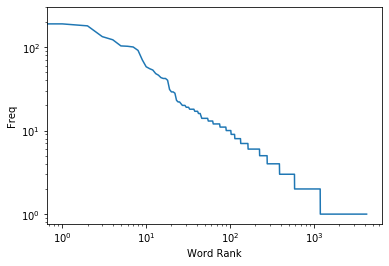

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
word_counts = sorted(Counter(words).values(), reverse=True)

plt.loglog(word_counts)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

## Generating histograms of words, screen names, and hashtags

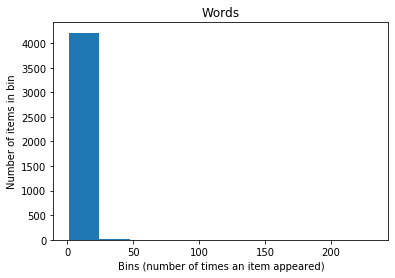

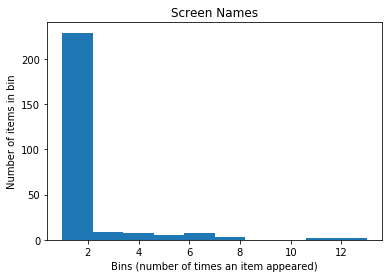

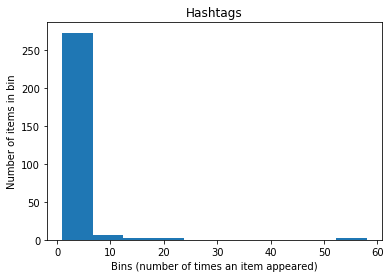

<Figure size 432x288 with 0 Axes>

In [59]:
for label, data in (('Words', words), 
                    ('Screen Names', screen_names), 
                    ('Hashtags', hashtags)):

    # Build a frequency map for each set of data
    # and plot the values
    c = Counter(data)
    plt.hist(list(c.values()))
    
    # Add a title and y-label ...
    plt.title(label)
    plt.ylabel("Number of items in bin")
    plt.xlabel("Bins (number of times an item appeared)")
    
    # ... and display as a new figure
    plt.figure()

## Generating a histogram of retweet counts

Text(0, 0.5, 'Number of tweets in bin')

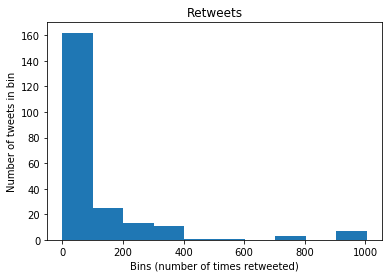

In [60]:
# Using underscores while unpacking values in
# a tuple is idiomatic for discarding them

counts = [count for count, _, _, _ in retweets]

plt.hist(counts)
plt.title('Retweets')
plt.xlabel('Bins (number of times retweeted)')
plt.ylabel('Number of tweets in bin')

## Sentiment Analysis

In [17]:
# pip install nltk
import nltk
nltk.download('vader_lexicon')

import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/mabramia/nltk_data...


In [18]:
twitter_stream = twitter.TwitterStream(auth=auth)
iterator = twitter_stream.statuses.sample()

In [19]:
tweets = []
for tweet in iterator:
    try:
        if tweet['lang'] == 'en':
            tweets.append(tweet)
    except:
        pass
    if len(tweets) == 100:
        break

In [20]:
analyzer = SentimentIntensityAnalyzer()

In [21]:
analyzer.polarity_scores('Hello')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [22]:
analyzer.polarity_scores('I really enjoy this video series.')

{'neg': 0.0, 'neu': 0.534, 'pos': 0.466, 'compound': 0.5413}

In [23]:
analyzer.polarity_scores('I REALLY enjoy this video series.')

{'neg': 0.0, 'neu': 0.486, 'pos': 0.514, 'compound': 0.64}

In [24]:
analyzer.polarity_scores('I REALLY enjoy this video series!!!')

{'neg': 0.0, 'neu': 0.439, 'pos': 0.561, 'compound': 0.7271}

In [25]:
analyzer.polarity_scores('I REALLY did not enjoy this video series!!!')

{'neg': 0.425, 'neu': 0.575, 'pos': 0.0, 'compound': -0.6627}

In [27]:
scores = np.zeros(len(tweets))

for i, t in enumerate(tweets):
    # Extract the text portion of the tweet
    text = t['text']
    
    # Measure the polarity of the tweet
    polarity = analyzer.polarity_scores(text)
    
    # Store the normalized, weighted composite score
    scores[i] = polarity['compound']

In [28]:
most_positive = np.argmax(scores)
most_negative = np.argmin(scores)

In [29]:
print('{0:6.3f} : "{1}"'.format(scores[most_positive], tweets[most_positive]['text']))

 0.962 : "RT @BTSUKUNITE: Jungkook amazing
Jungkook vocal
Jungkook wonderful
Jungkook talented
Jungkook golden
Jungkook perfect

Jungkook...We love y…"


In [30]:
print('{0:6.3f} : "{1}"'.format(scores[most_negative], tweets[most_negative]['text']))

-0.868 : "RT @AndycLufc: I have decided to break my silence on this matter, i am still shaking from this horrific assault, the sight of a high viz ja…"
